In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import torch
import torch.nn as nn
import datasets
import transformers
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [3]:
import lovely_tensors as lt

lt.monkey_patch()

In [4]:
data = datasets.load_dataset("alkzar90/CC6204-Hackaton-Cub-Dataset")
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data, test_data = data["train"], data["test"]
train_data

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 5994
})

4674
yellow eye ring around a black eye and beak is rather straight
this bird has a large eyering that is colored yellow with blue feathers on the top part of its body.
a small bird wi yellow eye rings, a light green under belly, and long tail feathers.
small whith bird with gray hood, black wings with white wingbars, and white eye.
the birds has a grey crown and nape area with it's breast, throat and belly in white color.
this bird is grey with white and has a very short beak.
this small light-green bird has a yellowish tint around its medium sized beak.
this particular bird has a belly that is white and tan
a small bird with a white belly and breast and grey head along with yellow eyerings.
this bird has a white and yellow belly, with yellow on the eyering, and two white wingbars.



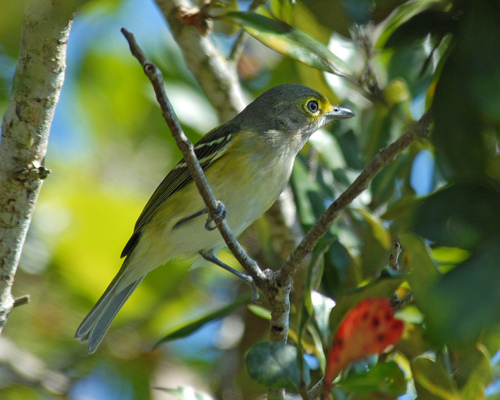

155


In [5]:
def match_random_sample():
    n = np.random.randint(0, len(train_data))
    print(n)
    print(train_data[n]["description"])
    train_data[n]["image"].show()
    print(train_data[n]["label"])


match_random_sample()

In [6]:
from transformers import BertTokenizer, BertModel
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
image_model.classifier[-1] = nn.Linear(2048, 768)
image_model = image_model.to(device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_model = BertModel.from_pretrained("bert-base-uncased")
text_model = text_model.to(device)


embedding_sim = nn.CosineSimilarity()


def batch_image_embed(batch):
    input_data = processor(images=batch, return_tensors="pt")
    input_data = input_data.to(device)
    return image_model(**input_data).logits


def batch_text_embed(batch):
    encoded_input = tokenizer(batch, return_tensors="pt", padding=True)
    encoded_input = encoded_input.to(device)
    output = text_model(**encoded_input).last_hidden_state
    return output.mean(dim=1)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
img = train_data[0]['image']
text = train_data[0]['description']

img_e = batch_image_embed(img)
text_e = batch_text_embed(text)

img_e.shape, text_e.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

In [8]:
#freeze BERT and ResNet parameters

for param in image_model.parameters():
    param.requires_grad = False

for param in text_model.parameters():
    param.requires_grad = False

In [9]:
#randK quantization
def quantize_vector(vector, K):
    # vector shape = (batch_size, N)
    to_zero = vector.shape[1] - K
    indices = torch.randperm(vector.shape[1])[:to_zero]
    vector[:,indices] = 0
    return vector

In [10]:
a = torch.randint(5, 10, size=(5, 5))
a = quantize_vector(a, 1)
a.v

tensor[5, 5] i64 n=25 x∈[0, 9] μ=1.560 σ=3.203
tensor([[0, 0, 8, 0, 0],
        [0, 0, 8, 0, 0],
        [0, 0, 7, 0, 0],
        [0, 0, 9, 0, 0],
        [0, 0, 7, 0, 0]])

In [11]:
class LinearModel(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.linear1 = nn.Linear(2 * 768, 200) # 2 * d -> num_classes
        self.K = K
    def forward(self, images, texts):
        img_e = batch_image_embed(images)
        text_e = batch_text_embed(texts)
        img_e = quantize_vector(img_e, self.K)
        text_e = quantize_vector(text_e, self.K)
        # print((img_e == 0).sum())
        # print(img_e.shape)
        MLP_input = torch.cat((img_e, text_e), dim=1)
        x = self.linear1(MLP_input)
        return x

In [12]:
def convert_img(elem):
    return elem['image'].mode == "RGB"


train_data = train_data.shuffle()
train_data = train_data.filter(convert_img, num_proc=16)

ids = np.array(range(len(test_data)))
rand_ids = np.random.choice(ids, size=1000, replace=False)
val_data = test_data.select(rand_ids)
val_data = val_data.filter(convert_img, num_proc=16)
val_data

Filter (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 1000
})

In [13]:
def validate(model):
    loss_hist = []
    true_preds = 0
    sum_loss = 0
    processed_samples = 0
    progress = tqdm(range(0, len(val_data) - batch_size, batch_size))
    with torch.no_grad():
        for j in progress:
            batch = val_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
    print(f"Mean val Loss: {sum_loss / (processed_samples / batch_size)}")
    print(f"Val accuracy: {true_preds / processed_samples}")
    print(processed_samples)

In [14]:
def train(model):
    loss_hist = []
    for i in range(epoch_num):
        print('EPOCH: ', i+1)
        true_preds = 0
        sum_loss = 0
        processed_samples = 0
        progress = tqdm(range(0, len(train_data) - batch_size, batch_size))
        lin_model.train()
        for j in progress:
            optimizer.zero_grad()

            batch = train_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
        print(f"Mean epoch Loss: {sum_loss / (processed_samples / batch_size)}")
        print(f"Epoch accuracy: {true_preds / processed_samples}")
        validate(model)
        print('='*75)
    return loss_hist

In [15]:
hists = []
ks = [100, 200, 400, 500, 768]

for k in ks:
    lin_model = LinearModel(k).to(device)
    loss_fun = nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.AdamW(lin_model.parameters(), lr)
    epoch_num = 10
    batch_size = 16
    loss_hist = train(lin_model)
    hists.append(loss_hist)
    torch.cuda.empty_cache()

EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.299434214352287
Epoch accuracy: 0.007185828877005348


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 5.247636941171462
Val accuracy: 0.014112903225806451
992
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.223962394948949
Epoch accuracy: 0.02807486631016043


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 5.1837151973478255
Val accuracy: 0.04838709677419355
992
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.148723121632867
Epoch accuracy: 0.07102272727272728


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 5.114771035409743
Val accuracy: 0.06955645161290322
992
EPOCH:  4


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.084851465123222
Epoch accuracy: 0.09107620320855615


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 5.061942554289295
Val accuracy: 0.10786290322580645
992
EPOCH:  5


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.025151586787586
Epoch accuracy: 0.11731283422459893


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.985230707353161
Val accuracy: 0.1381048387096774
992
EPOCH:  6


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.960911744418628
Epoch accuracy: 0.14371657754010694


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.936659851381855
Val accuracy: 0.14818548387096775
992
EPOCH:  7


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.897987848934643
Epoch accuracy: 0.1711229946524064


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.8714768809656945
Val accuracy: 0.1693548387096774
992
EPOCH:  8


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.839729343506104
Epoch accuracy: 0.1858288770053476


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.8470397610818186
Val accuracy: 0.1663306451612903
992
EPOCH:  9


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.779884547473275
Epoch accuracy: 0.20220588235294118


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.777955470546599
Val accuracy: 0.18044354838709678
992
EPOCH:  10


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.720018725981687
Epoch accuracy: 0.22443181818181818


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.719885818419918
Val accuracy: 0.2056451612903226
992
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.26961075558382
Epoch accuracy: 0.020053475935828877


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 5.125476929449266
Val accuracy: 0.07258064516129033
992
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.056826789111377
Epoch accuracy: 0.08856951871657753


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.9529544845704105
Val accuracy: 0.13911290322580644
992
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.877671694373064
Epoch accuracy: 0.15558155080213903


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.787145499260195
Val accuracy: 0.18951612903225806
992
EPOCH:  4


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.705104362518392
Epoch accuracy: 0.21908422459893048


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.632618496494908
Val accuracy: 0.22278225806451613
992
EPOCH:  5


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.538989204773928
Epoch accuracy: 0.26687834224598933


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.4863542356798725
Val accuracy: 0.2762096774193548
992
EPOCH:  6


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.382182610226187
Epoch accuracy: 0.2947860962566845


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.337282119258758
Val accuracy: 0.29536290322580644
992
EPOCH:  7


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.234912375715327
Epoch accuracy: 0.34191176470588236


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.2100495253839805
Val accuracy: 0.3004032258064516
992
EPOCH:  8


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.098909306653681
Epoch accuracy: 0.3693181818181818


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.086836184224775
Val accuracy: 0.3387096774193548
992
EPOCH:  9


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.9677893299469975
Epoch accuracy: 0.3962232620320856


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.97966238375633
Val accuracy: 0.32560483870967744
992
EPOCH:  10


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.846785928476303
Epoch accuracy: 0.4253008021390374


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.870983385270642
Val accuracy: 0.37399193548387094
992
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.160742763529487
Epoch accuracy: 0.0464572192513369


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.823212246741018
Val accuracy: 0.1381048387096774
992
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.628742474285676
Epoch accuracy: 0.1686163101604278


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.402744762359127
Val accuracy: 0.23084677419354838
992
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.183858455183672
Epoch accuracy: 0.2782419786096257


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.010458173290376
Val accuracy: 0.31451612903225806
992
EPOCH:  4


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.800249961608234
Epoch accuracy: 0.37182486631016043


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.709932573380009
Val accuracy: 0.3487903225806452
992
EPOCH:  5


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.4791389161890205
Epoch accuracy: 0.4520387700534759


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.4429535442782986
Val accuracy: 0.4102822580645161
992
EPOCH:  6


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.2081529851903254
Epoch accuracy: 0.49364973262032086


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.2243702834652317
Val accuracy: 0.4465725806451613
992
EPOCH:  7


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.972220956322981
Epoch accuracy: 0.5514705882352942


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.025468518657069
Val accuracy: 0.49798387096774194
992
EPOCH:  8


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.7697787915959076
Epoch accuracy: 0.5855614973262032


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.8801709951892978
Val accuracy: 0.5040322580645161
992
EPOCH:  9


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.593471014882154
Epoch accuracy: 0.6184826203208557


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.7312756680673167
Val accuracy: 0.5131048387096774
992
EPOCH:  10


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.4323529132547224
Epoch accuracy: 0.6450534759358288


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.596609438619306
Val accuracy: 0.530241935483871
992
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.096202546899969
Epoch accuracy: 0.05932486631016043


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.656043614110639
Val accuracy: 0.18548387096774194
992
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.390874553491725
Epoch accuracy: 0.20404411764705882


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.09723444907896
Val accuracy: 0.28024193548387094
992
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.834730538454923
Epoch accuracy: 0.330548128342246


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.6521887356235134
Val accuracy: 0.3528225806451613
992
EPOCH:  4


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.3896628815860033
Epoch accuracy: 0.4363302139037433


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.2981033786650626
Val accuracy: 0.3961693548387097
992
EPOCH:  5


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.0279687088441083
Epoch accuracy: 0.5170454545454546


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.0273096599886493
Val accuracy: 0.4657258064516129
992
EPOCH:  6


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.7362101996008725
Epoch accuracy: 0.5765374331550802


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.7904465083153016
Val accuracy: 0.5080645161290323
992
EPOCH:  7


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.492524410314101
Epoch accuracy: 0.6221590909090909


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.6164071713724444
Val accuracy: 0.5171370967741935
992
EPOCH:  8


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.2858165783040665
Epoch accuracy: 0.6515708556149733


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.4719792508309886
Val accuracy: 0.5272177419354839
992
EPOCH:  9


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.110335133929941
Epoch accuracy: 0.6834893048128342


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.33075354560729
Val accuracy: 0.5594758064516129
992
EPOCH:  10


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.958942737490098
Epoch accuracy: 0.7065508021390374


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.2052316915604377
Val accuracy: 0.5987903225806451
992
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.905986102507076
Epoch accuracy: 0.08272058823529412


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 4.220562888729956
Val accuracy: 0.17540322580645162
992
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.7662108059235435
Epoch accuracy: 0.28191844919786097


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 3.4252993714424873
Val accuracy: 0.3094758064516129
992
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 3.0267768167556928
Epoch accuracy: 0.4395053475935829


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.900959860893988
Val accuracy: 0.4173387096774194
992
EPOCH:  4


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.512491114318052
Epoch accuracy: 0.558322192513369


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.536138747968981
Val accuracy: 0.4949596774193548
992
EPOCH:  5


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 2.137216786331034
Epoch accuracy: 0.6310160427807486


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.2713904957617483
Val accuracy: 0.5393145161290323
992
EPOCH:  6


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.8535214362934949
Epoch accuracy: 0.6891711229946524


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 2.0731252854870212
Val accuracy: 0.5816532258064516
992
EPOCH:  7


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.632502199494265
Epoch accuracy: 0.7302807486631016


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 1.9205377621035422
Val accuracy: 0.6018145161290323
992
EPOCH:  8


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.4556213987064872
Epoch accuracy: 0.7628676470588235


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 1.8001738921288521
Val accuracy: 0.6159274193548387
992
EPOCH:  9


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.3106920151787007
Epoch accuracy: 0.7897727272727273


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 1.7031412720680237
Val accuracy: 0.6270161290322581
992
EPOCH:  10


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.1895058475394937
Epoch accuracy: 0.8109959893048129


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 1.6234373181096968
Val accuracy: 0.6431451612903226
992


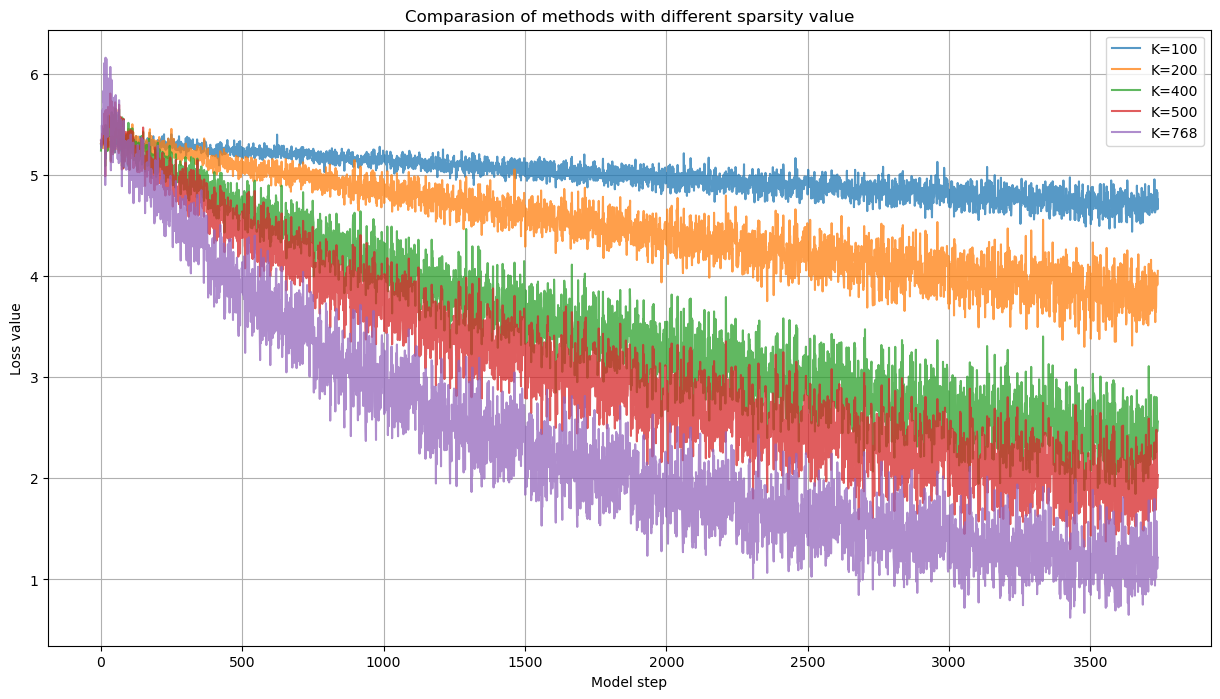

In [16]:
import matplotlib.pyplot as plt
# Smoothing function using a moving average
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Define the window size for the moving average
window_size = 10

# Smooth the loss data using the moving average


plt.figure(figsize=(15, 8))
for i, loss_hist in enumerate(hists):
    label = f"K={ks[i]}"
    plt.plot(loss_hist, alpha=0.75, label=label)
plt.grid()
plt.title('Comparasion of methods with different sparsity value')
plt.xlabel('Model step')
plt.ylabel('Loss value')
plt.legend()
plt.savefig('sparsiti_level_comparison_10.png')
# plt.show()

In [17]:
np.save('sparsity_res_10.npy', hists)